<a href="https://colab.research.google.com/github/SP-TechForest/Heart_Disease_Detection_Using_MLJAR/blob/main/Heart_Disease_Detection_WithMLJAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install boruta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 56 kB 1.4 MB/s 


In [57]:
!pip install mljar-supervised

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 112 kB 8.1 MB/s 
     |████████████████████████████████| 193.6 MB 53 kB/s 
     |████████████████████████████████| 2.0 MB 45.8 MB/s 
     |████████████████████████████████| 76.6 MB 21 kB/s 
     |████████████████████████████████| 72 kB 817 kB/s 
     |████████████████████████████████| 575 kB 52.7 MB/s 
     |████████████████████████████████| 72 kB 859 kB/s 
     |████████████████████████████████| 348 kB 43.9 MB/s 
     |████████████████████████████████| 81 kB 8.1 MB/s 
     |████████████████████████████████| 209 kB 44.5 MB/s 
     |████████████████████████████████| 78 kB 6.4 MB/s 
     |████████████████████████████████| 50 kB 5.8 MB/s 
     |████████████████████████████████| 147 kB 52.8 MB/s 
     |████████████████████████████████| 112 kB 51.3 MB/s 
  Created wheel for mljar-supervised: filename=mljar_supervised-0.11.3-py3-none-any.whl size=146656 s

In [2]:
import pandas as pd 
import plotly.express as px
import seaborn as sns 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

In [3]:
data = pd.read_csv('framingham.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4240 non-null   int64  
 1   age              4240 non-null   int64  
 2   education        4135 non-null   float64
 3   currentSmoker    4240 non-null   int64  
 4   cigsPerDay       4211 non-null   float64
 5   BPMeds           4187 non-null   float64
 6   prevalentStroke  4240 non-null   int64  
 7   prevalentHyp     4240 non-null   int64  
 8   diabetes         4240 non-null   int64  
 9   totChol          4190 non-null   float64
 10  sysBP            4240 non-null   float64
 11  diaBP            4240 non-null   float64
 12  BMI              4221 non-null   float64
 13  heartRate        4239 non-null   float64
 14  glucose          3852 non-null   float64
 15  TenYearCHD       4240 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 530.1 KB


In [5]:
data.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


Education is not related to having heart disease or not. so, first i am removing education column. 

In [6]:
data.drop(columns = ['education'], inplace = True)

In [7]:
null_columns = data.columns[data.isna().any()]
null_columns

Index(['cigsPerDay', 'BPMeds', 'totChol', 'BMI', 'heartRate', 'glucose'], dtype='object')

In [8]:
def plot_null(temp_data):
  total = temp_data.isnull().sum().sort_values(ascending=False)
  percent_total = (temp_data.isnull().sum()/temp_data.isnull().count()).sort_values(ascending=False)*100
  missing = pd.concat([total, percent_total], axis=1, keys=["Total", "Percentage"])
  return missing[missing['Total']>0]
missing_data = plot_null(data)
missing_data

,Total,Percentage
glucose,388,9.150943
BPMeds,53,1.250000
totChol,50,1.179245
cigsPerDay,29,0.683962
BMI,19,0.448113
heartRate,1,0.023585


In [9]:
px.bar(x = missing_data.index, y = missing_data['Total'], title = "Missing values", labels={'x':"columns",'y':'Number of missing values'})

In [10]:
data.shape

(4240, 15)

In [11]:
data.dropna().shape # After removing null values we are still getting sufficient amount of data for analysis and prediction

(3751, 15)

In [12]:
data.dropna(inplace = True)
plot_null(data)

,Total,Percentage


In [13]:
def plot_graph(df, variable,target):
    plt.figure(figsize=(20, 4))
    
    sns.set_style("dark")
    # histogram
    plt.subplot(1, 4, 1)
    sns.histplot(data = df,x = variable, bins=30,hue = target, multiple = 'stack')
    plt.title('Histogram')
    # scatterplot
    plt.subplot(1, 4, 2)
    plt.scatter(df[variable],df[target],color = 'g')
    plt.title('Scatterplot')  
    # boxplot
    plt.subplot(1, 4, 3)
    sns.boxplot(y=df[variable],color = 'b')
    plt.title('Boxplot')
    # barplot
    plt.subplot(1, 4, 4)
    sns.barplot(x = target, y = variable, data = df)   
    plt.title('Barplot')
    plt.show()

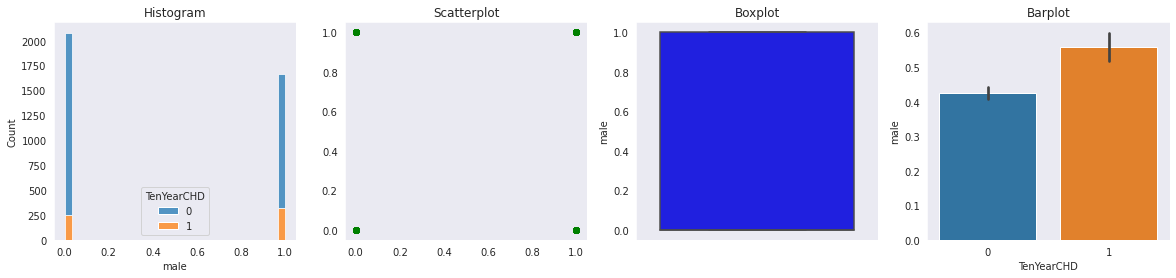

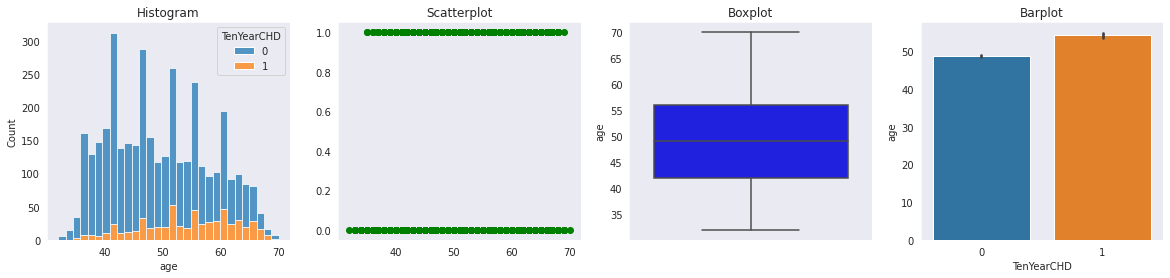

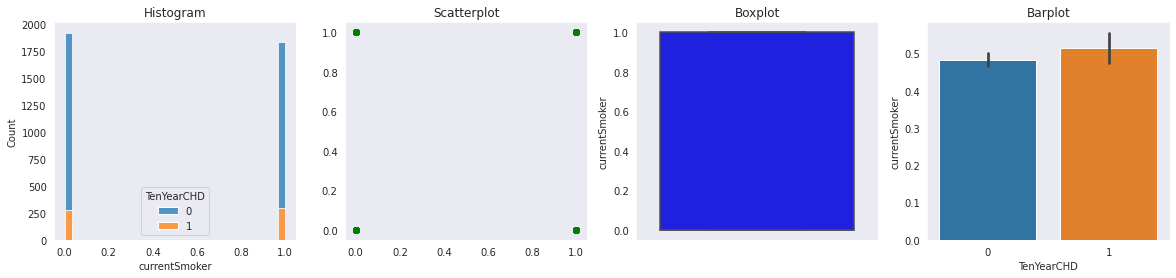

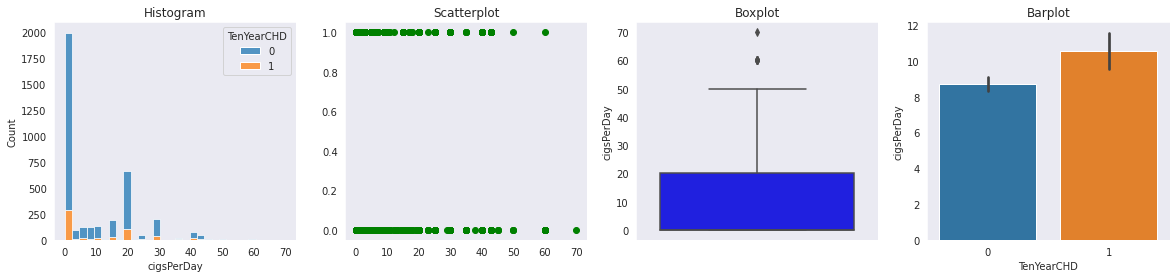

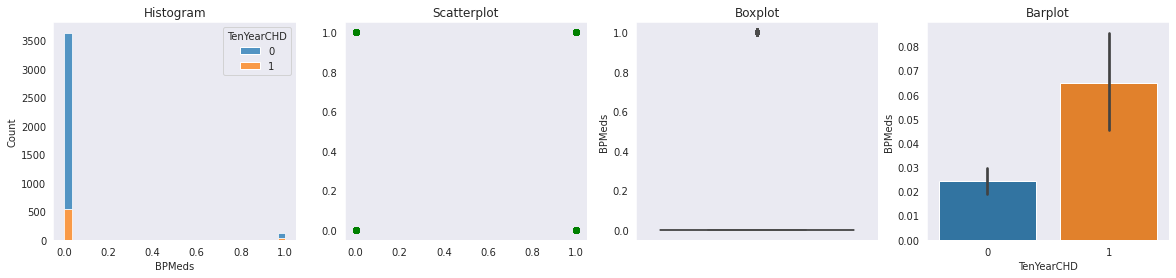

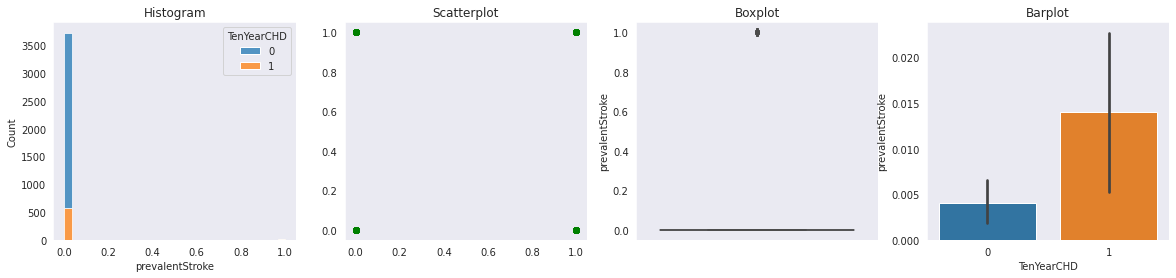

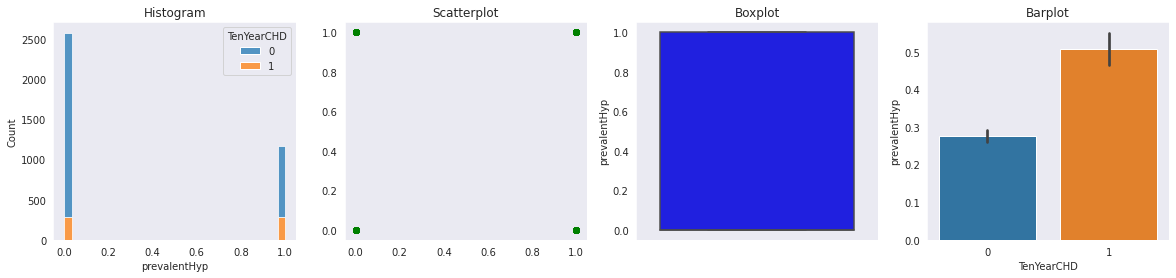

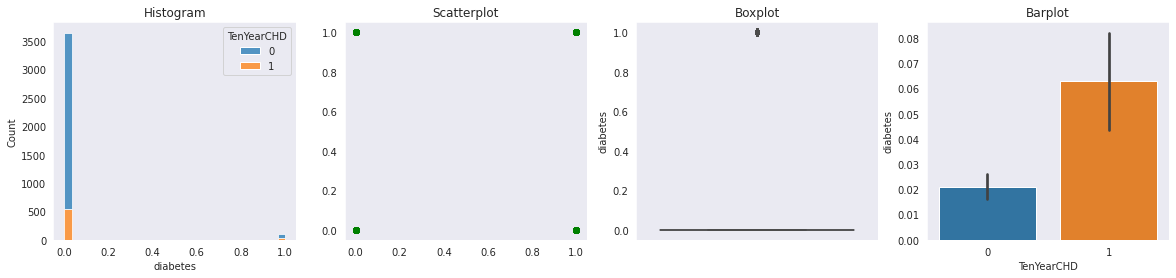

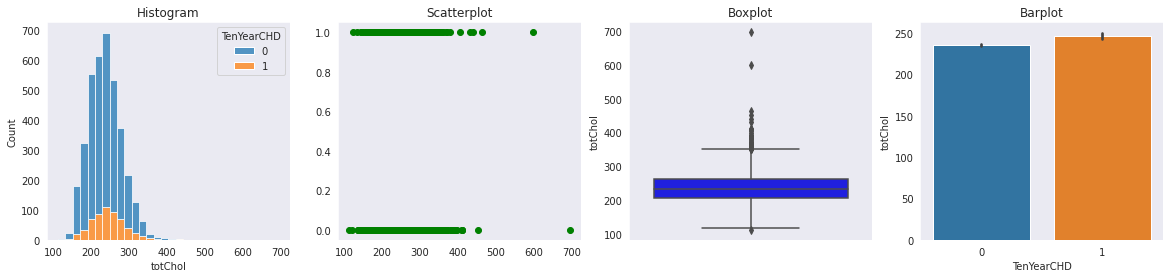

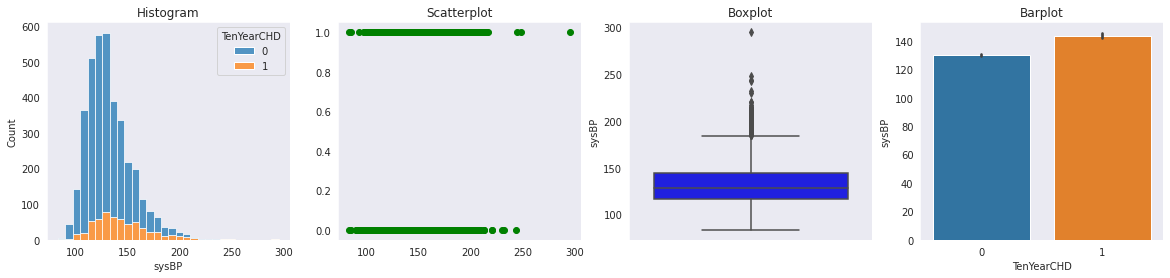

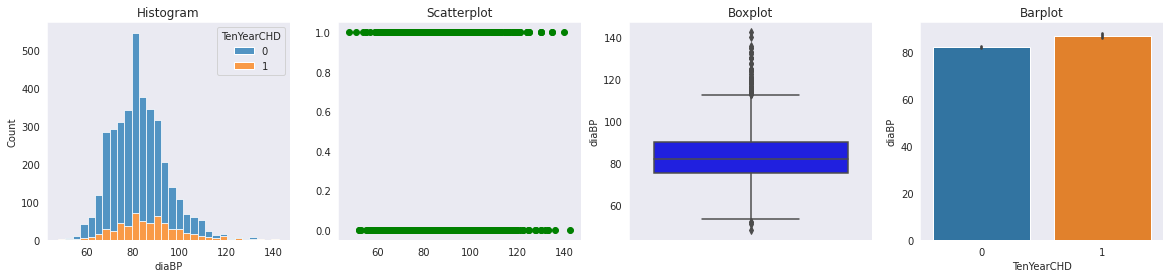

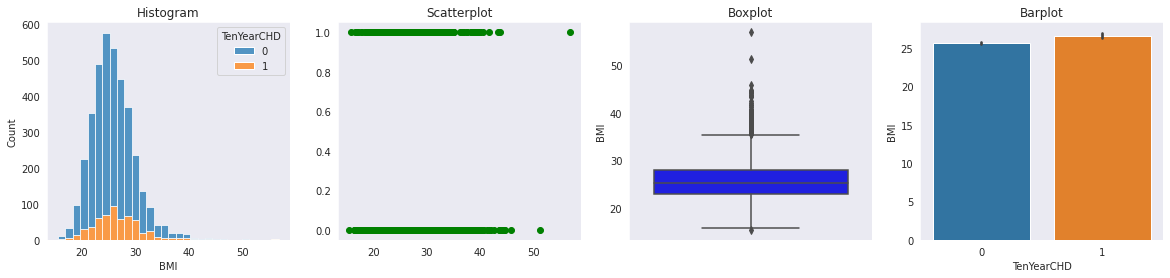

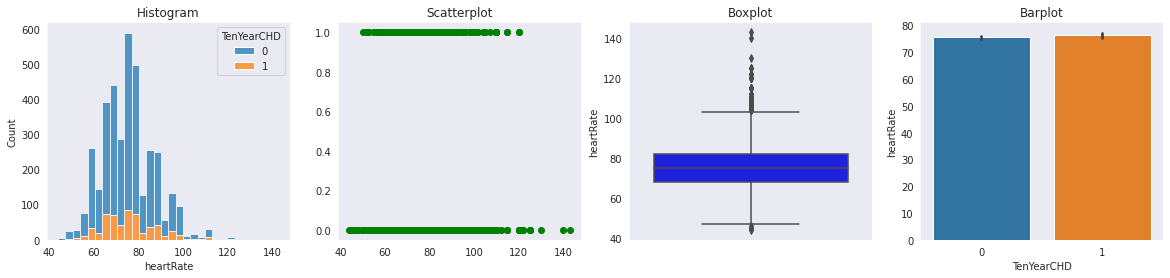

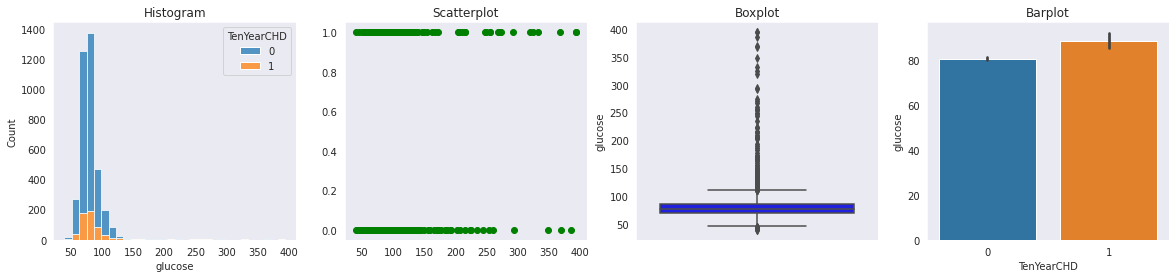

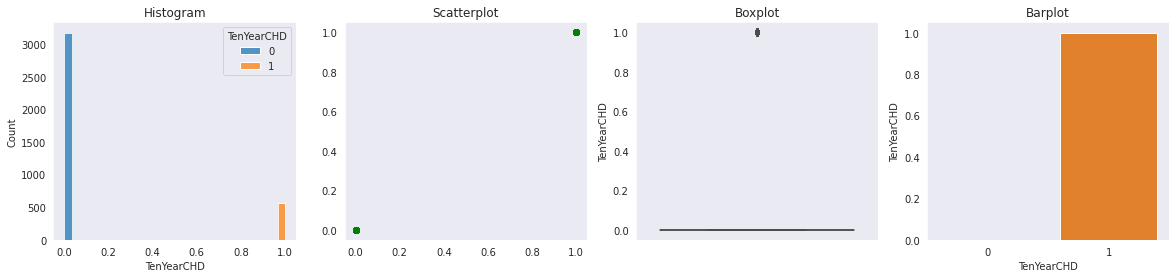

In [14]:
for variable in data:
    plot_graph(data , variable, 'TenYearCHD')

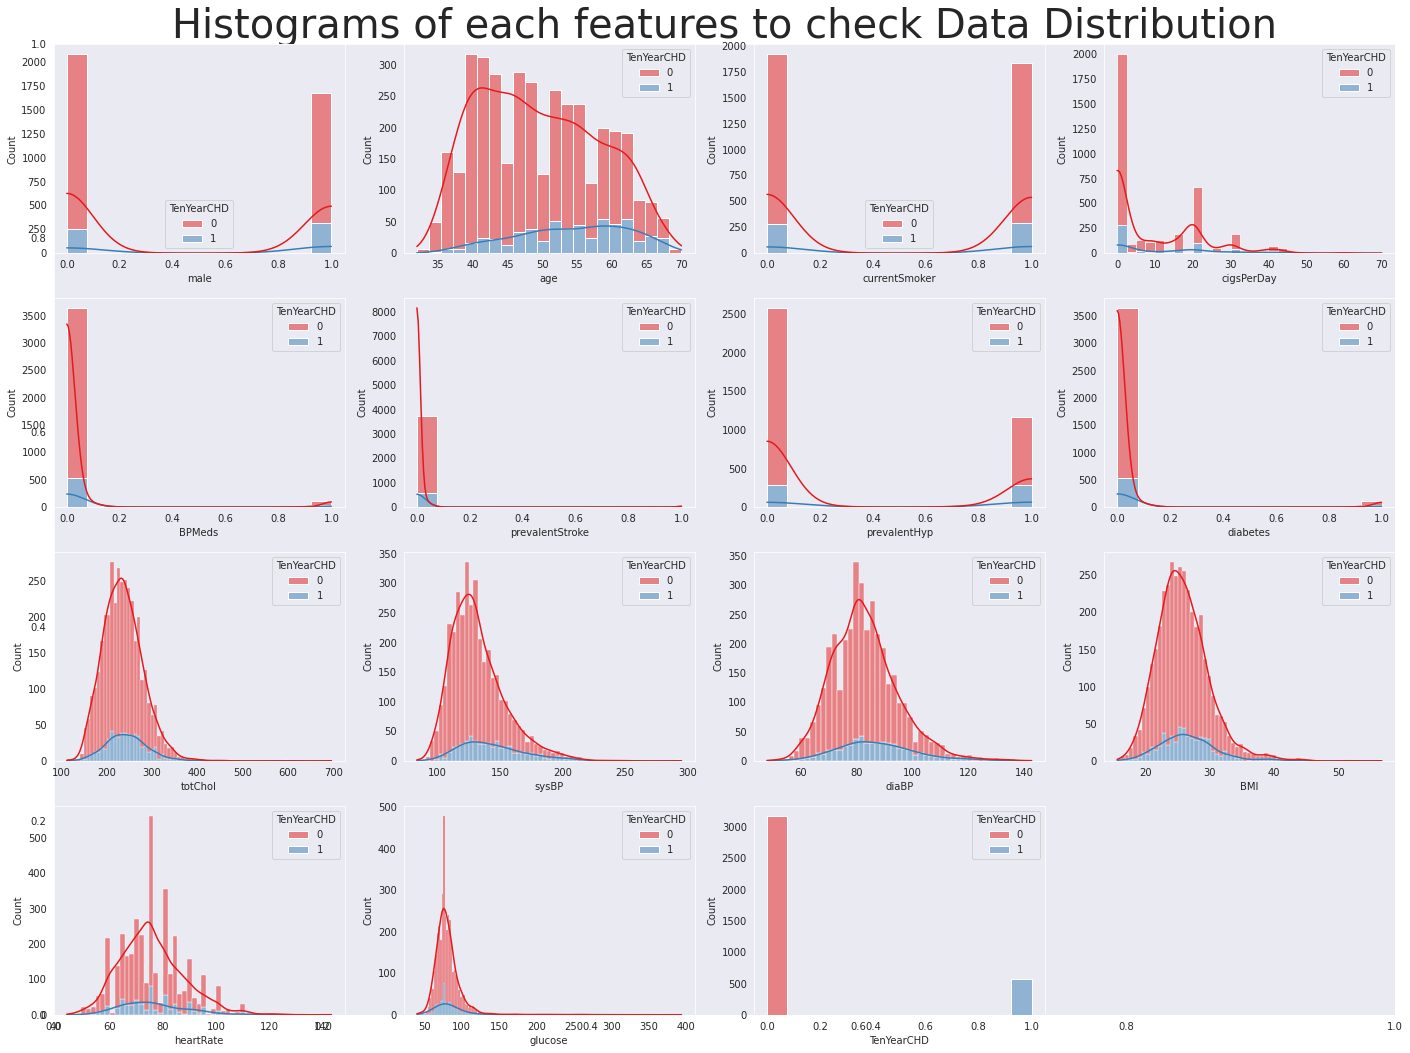

In [15]:
fig = plt.figure(figsize=(20,15))
plt.title("Histograms of each features to check Data Distribution", fontsize = 40)
for i in range(len(data.columns)):
  sns.set_style("dark")
  fig.add_subplot(4,4,i+1)
  sns.histplot(x = data.iloc[:,i].dropna(), kde = True, hue = data.TenYearCHD,multiple='stack', palette='Set1')
  plt.xlabel(data.columns[i])

plt.tight_layout()
plt.show()


In [16]:
px.bar(y = data.TenYearCHD.value_counts(), title = "Imbalance in target column")

In [17]:
numeric_corr = data.select_dtypes(include=['int64','float64'])
numeric_corr = numeric_corr.corr()
mask = np.triu(np.ones_like(numeric_corr, dtype=np.bool))
numeric_corr = numeric_corr.mask(mask)

fig = go.Figure(data= go.Heatmap(z=numeric_corr.to_numpy().round(2),
                                 x=numeric_corr.index.values,
                                 y=numeric_corr.columns.values,
                                 colorscale=px.colors.sequential.GnBu,
                                 xgap = 3, ygap = 4
                                 )
                )
fig.update_layout(title_text='<b>Correlation Matrix<b>',
                  title_x=0.5,
                  titlefont={'size': 24},
                  width=800, height=800,
                  xaxis_showgrid=False,
                  yaxis_showgrid=False,
                  yaxis_autorange='reversed', 
                  paper_bgcolor='rgb(242,242,242)',
                  plot_bgcolor = 'rgb(56,156,166)'
                  )
fig.show()

<ipython-input-17-d9f1f3b2b487>:3: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [18]:
features = data.drop(columns = ['TenYearCHD']).values
target = data['TenYearCHD'].values

In [19]:
rfc = RandomForestClassifier(n_estimators=100, n_jobs=1, class_weight='balanced')
best_feature = BorutaPy(rfc,n_estimators='auto', verbose = 2)
best_feature.fit(features, target)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	2
Tentative: 	4
Rejected: 	8
Iteration: 	9 / 100
Confirmed: 	2
Tentative: 	4
Rejected: 	8
Iteration: 	10 / 100
Confirmed: 	2
Tentative: 	4
Rejected: 	8
Iteration: 	11 / 100
Confirmed: 	2
Tentative: 	4
Rejected: 	8
Iteration: 	12 / 100
Confirmed: 	2
Tentative: 	4
Rejected: 	8
Iteration: 	13 / 100
Confirmed: 	2
Tentative: 	4
Rejected: 	8
Iteration: 	14 / 100
Confirmed: 	2
Tentative: 	4
Rejected: 	8
Iteration: 	15 / 100
Confirmed: 	2
Tentative: 	4
Rejected: 	8
Iteration: 	16 / 100
Confirmed: 	2
Tentative: 	4
Rejected: 	8
Iteration:

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced',
                                          n_estimators=28, n_jobs=1,
                                          random_state=RandomState(MT19937) at 0x7FE5F006A640),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7FE5F006A640, verbose=2)

In [20]:
important_feature_BPY =data.columns[:-1][best_feature.support_]

In [21]:
from sklearn.feature_selection import RFE

In [22]:
rfeselector = RFE(rfc, n_features_to_select=5, step=1)
rfeselector = rfeselector.fit(features,target)

In [23]:
important_feature_RFE =data.columns[:-1][rfeselector.support_]
important_feature_RFE

Index(['age', 'totChol', 'sysBP', 'BMI', 'glucose'], dtype='object')

In [24]:
rfeselector.ranking_

array([ 5,  1,  7,  4,  8, 10,  6,  9,  1,  1,  2,  1,  3,  1])

In [25]:
{data.columns[i]: rfeselector.ranking_[i] for i in range(len(rfeselector.ranking_))}

{'male': 5,
 'age': 1,
 'currentSmoker': 7,
 'cigsPerDay': 4,
 'BPMeds': 8,
 'prevalentStroke': 10,
 'prevalentHyp': 6,
 'diabetes': 9,
 'totChol': 1,
 'sysBP': 1,
 'diaBP': 2,
 'BMI': 1,
 'heartRate': 3,
 'glucose': 1}

In [26]:
final_feature = data[important_feature_RFE].values
final_feature

array([[ 39.  , 195.  , 106.  ,  26.97,  77.  ],
       [ 46.  , 250.  , 121.  ,  28.73,  76.  ],
       [ 48.  , 245.  , 127.5 ,  25.34,  70.  ],
       ...,
       [ 52.  , 269.  , 133.5 ,  21.47, 107.  ],
       [ 40.  , 185.  , 141.  ,  25.6 ,  72.  ],
       [ 39.  , 196.  , 133.  ,  20.91,  80.  ]])

In [27]:
Counter(target)

Counter({0: 3179, 1: 572})

In [28]:
over = SMOTE(sampling_strategy=0.8)
under = RandomUnderSampler(sampling_strategy=0.8)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
x_smote, y_smote = pipeline.fit_resample(final_feature, target)

In [29]:
Counter(y_smote)

Counter({0: 3178, 1: 2543})

In [30]:
fig = make_subplots(
    rows = 1, cols = 2,
    subplot_titles=('Target distribution before SMOTE','Target distribution after SMOTE')
)
fig.add_trace(go.Histogram(x = target),row = 1, col = 1)
fig.add_trace(go.Histogram(x = y_smote),row = 1, col = 2)
fig.update_layout(height=550, width=700,barmode = 'group',bargap = 0.30,
                  title_text="Target balancing using SMOTE")

In [31]:
x_smote.shape, y_smote.shape

((5721, 5), (5721,))

In [38]:
final_features = pd.DataFrame(x_smote, columns = important_feature_RFE)

In [36]:
important_feature_RFE

Index(['age', 'totChol', 'sysBP', 'BMI', 'glucose'], dtype='object')

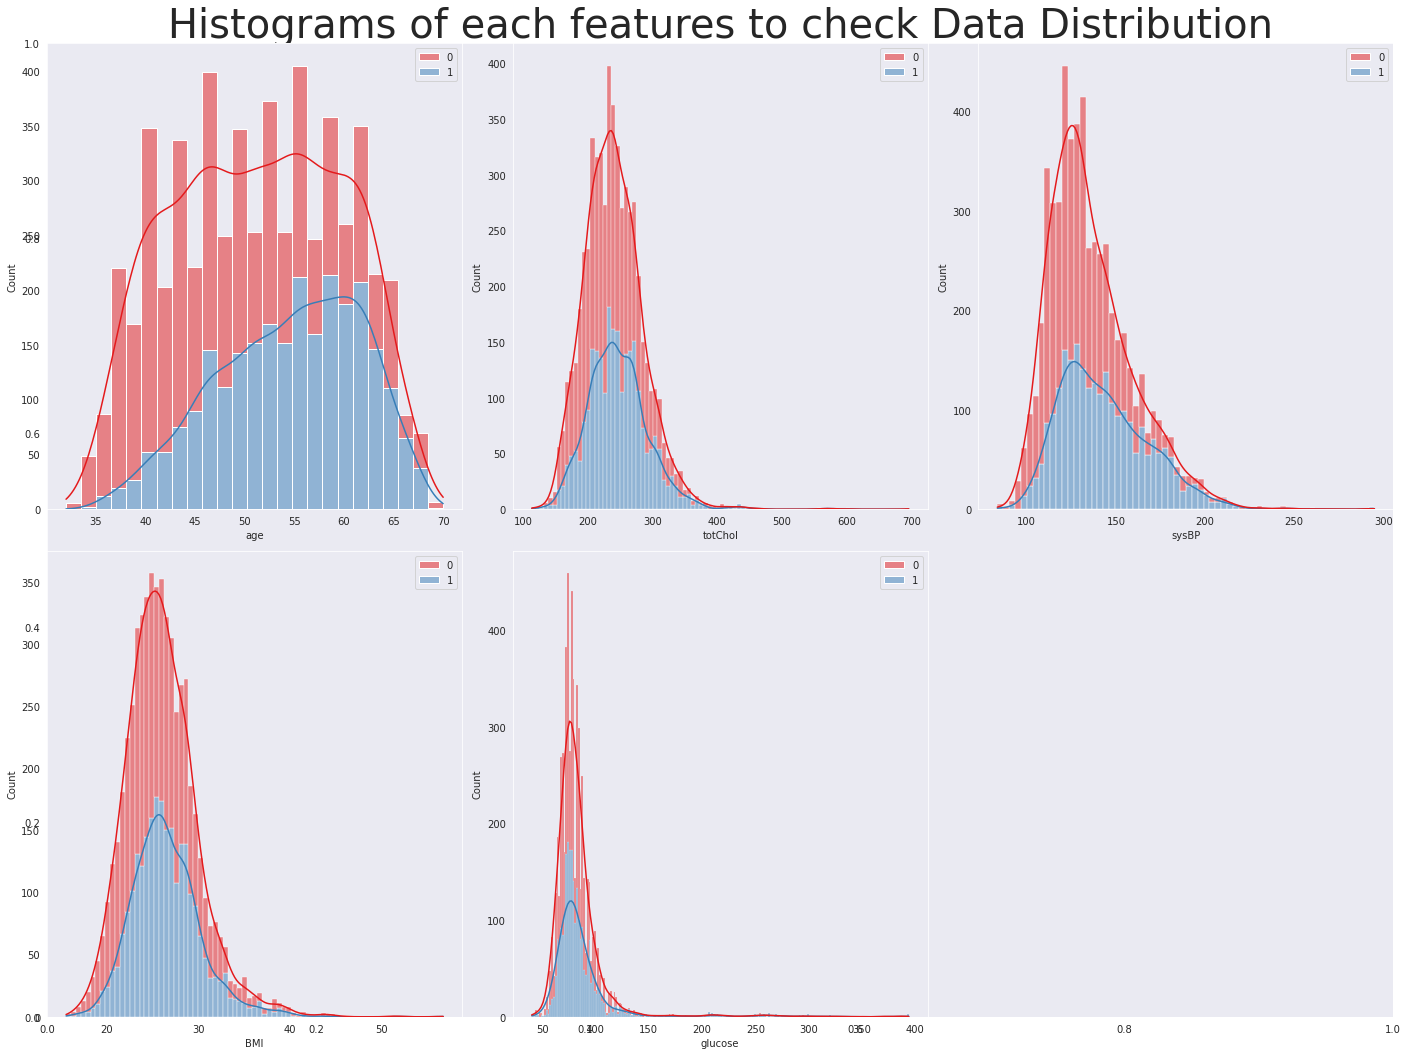

In [39]:
fig = plt.figure(figsize=(20,15))
plt.title("Histograms of each features to check Data Distribution", fontsize = 40)
for i in range(len(final_features.columns)):
  sns.set_style("dark")
  fig.add_subplot(2,3,i+1)
  sns.histplot(x = final_features.iloc[:,i].dropna(), kde = True, hue = y_smote,multiple='stack', palette='Set1')
  plt.xlabel(final_features.columns[i])

plt.tight_layout()
plt.show()

In [40]:
from sklearn.preprocessing import QuantileTransformer

In [41]:
temp_ff = final_features.copy()
qt = QuantileTransformer(n_quantiles=10, random_state=0)
temp_ff = qt.fit_transform(temp_ff)

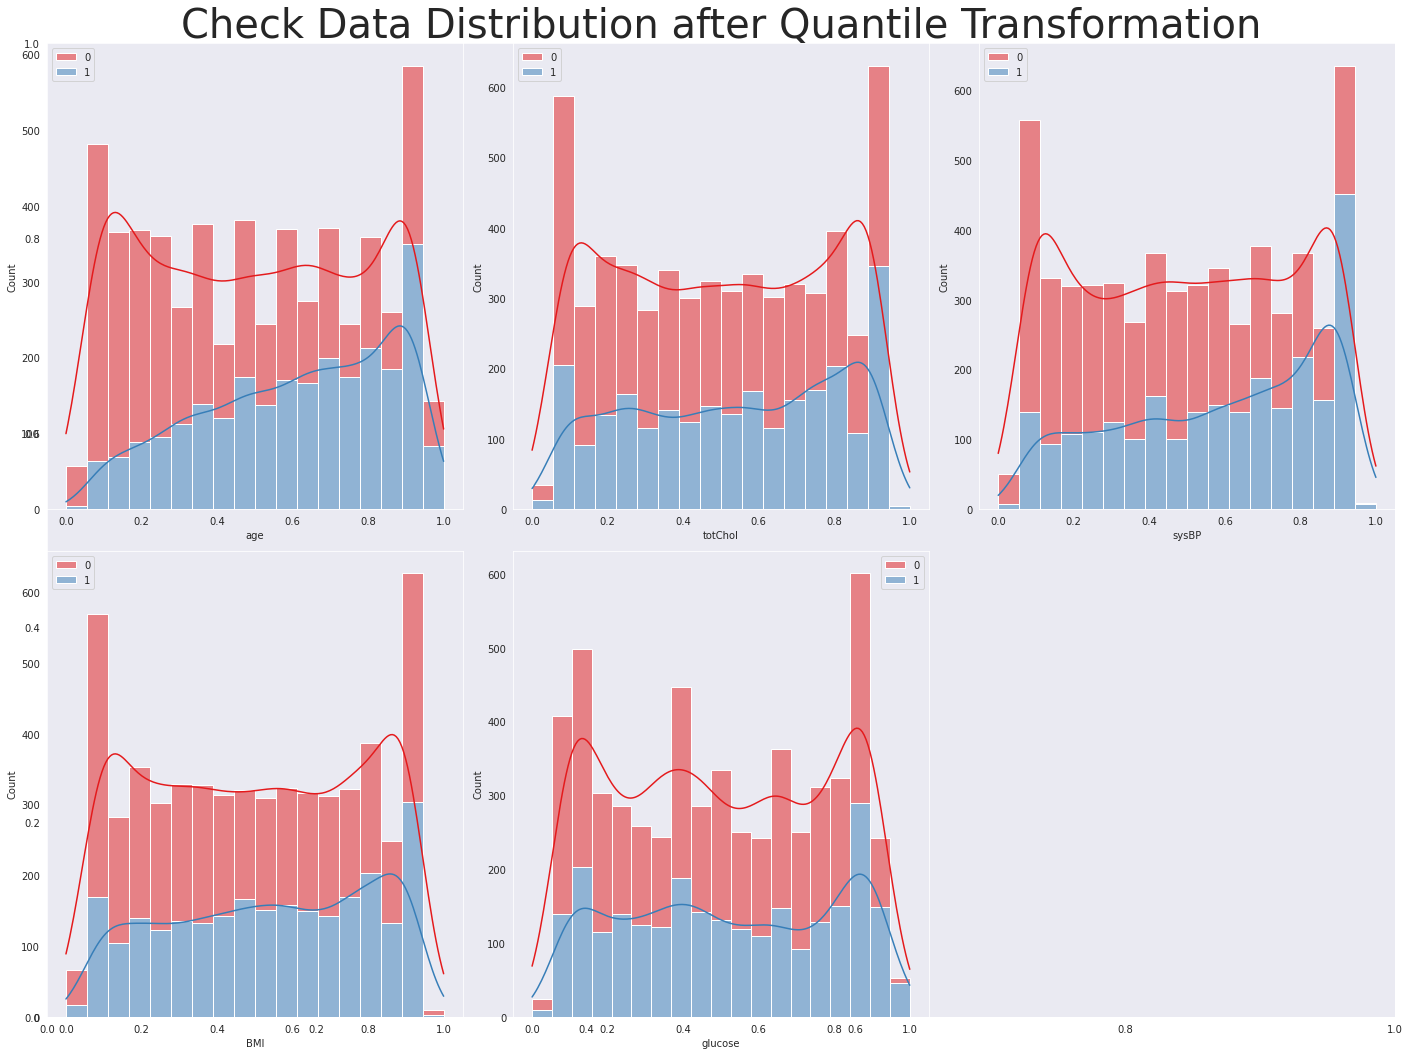

In [47]:
temp_ff = pd.DataFrame(temp_ff, columns = important_feature_RFE)
temp_ff
fig = plt.figure(figsize=(20,15))
plt.title("Check Data Distribution after Quantile Transformation", fontsize = 40)
for i in range(len(final_features.columns)):
  sns.set_style("dark")
  fig.add_subplot(2,3,i+1)
  sns.histplot(x = temp_ff.iloc[:,i].dropna(), kde = True, hue = y_smote,multiple='stack', palette='Set1')
  plt.xlabel(final_features.columns[i])

plt.tight_layout()
plt.show()

In [63]:
from sklearn.model_selection import train_test_split as tts 
from sklearn.metrics import classification_report

In [77]:
x_train, x_test, y_train, y_test = tts(temp_ff.values, y_smote, test_size=0.3, random_state=42)

In [78]:
from supervised import AutoML

In [83]:
automl = AutoML(mode = 'Explain', results_path='AutoML_30',features_selection=True )

In [84]:
automl.fit(x_train, y_train)

AutoML directory: AutoML_30
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'insert_random_feature', 'features_selection', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline logloss 0.687636 trained in 1.35 seconds
2_DecisionTree logloss 0.605805 trained in 5.14 seconds
3_Linear logloss 0.608126 trained in 3.42 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost logloss 0.361365 trained in 6.34 seconds
5_Default_NeuralNetwork logloss 0.597938 trained in 3.27 seconds
6_Default_RandomForest logloss 0.579155 trained in 6.48 seconds
* Step insert_random_feature will try to check up to 1 model
4_Default_Xgboost_RandomFeature logloss 0.375688 trained in 2.49 seconds
Drop features ['random_feature']
Skip fea

AutoML(features_selection=True, results_path='AutoML_30')

In [85]:
y_pred = automl.predict(x_test)

In [86]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       967
           1       0.85      0.78      0.81       750

    accuracy                           0.84      1717
   macro avg       0.84      0.83      0.84      1717
weighted avg       0.84      0.84      0.84      1717

